

<img src="https://drive.google.com/uc?export=view&id=1wpQMFbiopOgqZ8MMseUDCorEhxWVu9FM" width="450" height="400" align='right' />


## Amirkabir Artificial Intelligence Summer Summit

### Generative Adversarial Networks Workshop



#### Mohammad Rahmdel

www.github.com/Mohammad-Rahmdel


##### Amirkabir Artificial Intelligence Summer Summit
##### Computer Engineering Department of Amirkabir University of Technology




In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time

%matplotlib inline

In [ ]:
tf.random.set_seed(4)

In [ ]:
TRAIN_BUF=60000
BATCH_SIZE=512
TEST_BUF=10000
DIMS = (28,28,1)


## Fashion MNIST

In [ ]:
# load dataset
(train_images, labels), (test_images, _) = tf.keras.datasets.fashion_mnist.load_data()

In [ ]:
labels[:20]

array([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9, 1, 0, 6, 4],
      dtype=uint8)

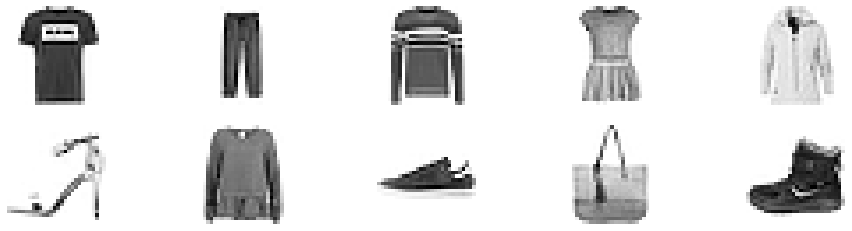

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(16, 4))

arr = [1,21,5,3,19,8,18,6,35,0]
index = 0
for row in ax:
    for col in row:
        col.imshow(train_images[arr[index]].squeeze(), cmap=plt.cm.Greys)
        col.axis('off')
        index += 1
        

In [ ]:
print(train_images.shape)

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32') / 255.0
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32') / 255.0

print(train_images.shape)


(60000, 28, 28)
(60000, 28, 28, 1)


In [ ]:
# batch datasets
train_dataset = (
    tf.data.Dataset.from_tensor_slices(train_images)
    .shuffle(TRAIN_BUF)
    .batch(BATCH_SIZE)
)
test_dataset = (
    tf.data.Dataset.from_tensor_slices(test_images)
    .shuffle(TEST_BUF)
    .batch(BATCH_SIZE)
)

In [ ]:
N_Z = 64

generator = tf.keras.Sequential([
    tf.keras.layers.Dense(units=7 * 7 * 64, activation='relu', input_shape=(N_Z,)),
    tf.keras.layers.Reshape(target_shape=(7, 7, 64)),
    tf.keras.layers.Conv2DTranspose(
        filters=64, kernel_size=3, strides=(2, 2), padding='same', activation='relu'
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=32, kernel_size=3, strides=(2, 2), padding='same', activation='relu'
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=1, kernel_size=3, strides=(1, 1), padding='same', activation='sigmoid'
    )
])

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 3136)              203840    
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         289       
Total params: 259,521
Trainable params: 259,521
Non-trainable params: 0
_________________________________________________________________


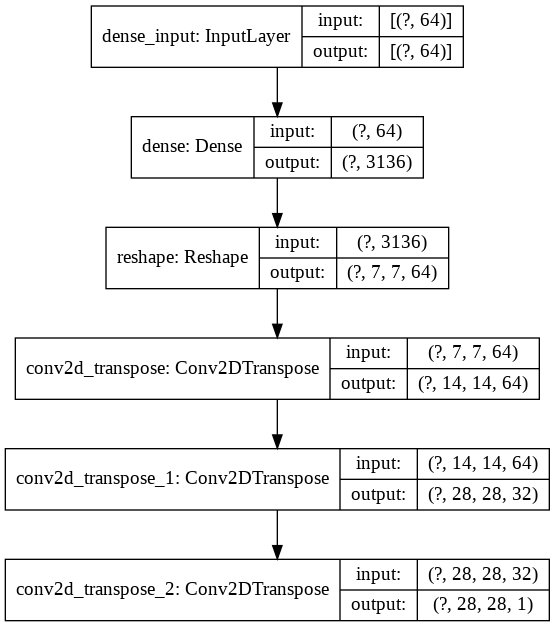

In [ ]:
tf.keras.utils.plot_model(generator, show_shapes=True)

In [ ]:
discriminator = tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation="relu"),
        tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation="relu"),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=1, activation='sigmoid')
    ])

In [ ]:
try:
    discriminator.summary()
except ValueError:
    print('ValueError: This model has not yet been built. Build the model first by calling `build()` or calling \n `fit()` with some data, or specify an `input_shape` argument in the first layer(s) for automatic build.')


ValueError: This model has not yet been built. Build the model first by calling `build()` or calling 
 `fit()` with some data, or specify an `input_shape` argument in the first layer(s) for automatic build.


In [ ]:
# optimizers
g_optimizer = tf.keras.optimizers.Adam(0.001, beta_1=0.5)
d_optimizer = tf.keras.optimizers.RMSprop(0.005)

In [ ]:
GAN_loss = tf.keras.losses.binary_crossentropy

In [ ]:
@tf.function
def train_step(x):
    with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
        
        z_samp = tf.random.normal([x.shape[0], N_Z])

        x_gen = generator(z_samp)

        D_fake = discriminator(x_gen)
        D_real = discriminator(x)

        D_loss = GAN_loss(tf.ones_like(D_real), D_real) + GAN_loss(tf.zeros_like(D_fake), D_fake)
        G_loss = GAN_loss(tf.ones_like(D_fake), D_fake)
        
    G_gradients = g_tape.gradient(G_loss, generator.trainable_variables)
    D_gradients = d_tape.gradient(D_loss, discriminator.trainable_variables)
    
    g_optimizer.apply_gradients(
    zip(G_gradients, generator.trainable_variables)
    )
    d_optimizer.apply_gradients(
        zip(D_gradients, discriminator.trainable_variables)
    )
    
    return D_loss, G_loss

In [ ]:
# noise = tf.random.normal([2 * 8, N_Z])

In [ ]:
def generate_and_save(noise, epoch, scale=1.5):

    x_gen = generator(noise)

    fig, axs = plt.subplots(ncols=8, nrows=2, figsize=(scale * 8, scale * 2))
    fig.patch.set_facecolor('white')

    for i in range(2):
        for j in range(8):
            axs[i,j].imshow(x_gen[i * 8 + j,:,:,0], cmap=plt.cm.Greys)
            axs[i,j].axis('off')
    plt.savefig('./' + str(epoch) + '.png')
    plt.close()

In [ ]:
GLosses = []
DLosses = []

def train(n_epochs=1, print_=False):

    for epoch in range(n_epochs):
        Gloss = Dloss = []
        for batch in train_dataset:
            D_loss, G_loss = train_step(batch)
            Gloss.append(tf.reduce_mean(G_loss))
            Dloss.append(tf.reduce_mean(D_loss))

        GLosses.append(np.mean(G_loss))
        DLosses.append(np.mean(D_loss))
        
        if print_:
            print(
            "Epoch: {} | disc_loss: {} | gen_loss: {}".format(
                epoch, DLosses[-1], GLosses[-1]
            ))

        # generate_and_save(noise, epoch)

In [ ]:
t1 = time.time()
train(100, print_=False)
t2 = time.time()
print('Token Time:', (t2-t1))

Token Time: 642.7707669734955



<img src="https://drive.google.com/uc?export=view&id=1ibe0-Y2N2Eu_cGbxWc_ZnJ2BUjOn1Eom" width="1200" height="400" align='right' />

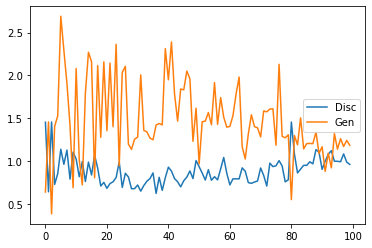

In [ ]:
plt.plot(DLosses, label="Disc")
plt.plot(GLosses, label="Gen")
plt.legend(loc=5)
plt.show()

In [ ]:
def generate_and_plot(rows, cols, scale=2):

    z_samp = tf.random.normal([rows * cols, N_Z])
    x_gen = generator(z_samp)

    fig, axs = plt.subplots(ncols=cols, nrows=rows, figsize=(scale * cols, scale * rows))
    fig.patch.set_facecolor('white')

    for i in range(rows):
        for j in range(cols):
            axs[i,j].imshow(x_gen[i * cols + j,:,:,0], cmap=plt.cm.Greys)
            axs[i,j].axis('off')
    
    plt.show()

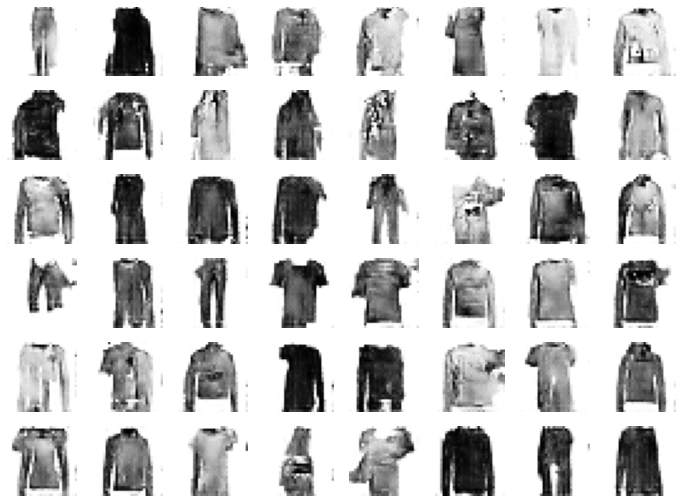

In [ ]:
generate_and_plot(6, 8, scale=1.5)

## Mode Collapse or Helvetica Scenario

The generator produces limited category images!

### Generated images after training for 300 epochs. 
More epochs better results?!?



<img src="https://drive.google.com/uc?export=view&id=1OKKTejJxpDCdR_m25cHHsyRkcngZNLGj" width="600" height="300" />
